# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Project 3: Web APIs & NLP

### Description

In week four we've learned about a few different classifiers. In week five we'll learn about webscraping, APIs, and Natural Language Processing (NLP). This project will put those skills to the test.

For project 3, your goal is two-fold:
1. Using [Pushshift's](https://github.com/pushshift/api) API, you'll collect posts from two subreddits of your choosing.
2. You'll then use NLP to train a classifier on which subreddit a given post came from. This is a binary classification problem.


#### About the API

Pushshift's API is fairly straightforward. For example, if I want the posts from [`/r/boardgames`](https://www.reddit.com/r/boardgames), all I have to do is use the following url: https://api.pushshift.io/reddit/search/submission?subreddit=boardgames

To help you get started, we have a primer video on how to use the API: https://youtu.be/eGi8jf1wHgw

---

### Requirements

- Gather and prepare your data using the `requests` library.
- **Create and compare two models**. One of these must be a Bayes classifier, however the other can be a classifier of your choosing: logistic regression, KNN, SVM, etc.
- A Jupyter Notebook with your analysis for a peer audience of data scientists.
- An executive summary of your results.
- A short presentation outlining your process and findings for a semi-technical audience.

**Pro Tip:** You can find a good example executive summary [here](https://www.proposify.biz/blog/executive-summary).

---

### Necessary Deliverables / Submission

- Code and executive summary must be in a clearly commented Jupyter Notebook.
- You must submit your slide deck.
- Materials must be submitted by **10:00 AM on Friday, January 31st**.

---

# Contents

- [Problem Statement](#Problem-Statement)

- [Executive Summary](#Executive-Summary)

- [Data Import](#Data-Import)

- [Data Pre-Processing](#Data-Pre-Processing)

- [Modeling](#Modeling)

- [Making Prediction on New Data](#Making-Prediction)




# Problem-Statement

A Japanese Food company (who sells all kind of staff related to food including cooking tools) would like to do advertising on blog web site (i.e. reddit.com). But the company has limited budget for this. We are hired to find an optimal way to carry out this task.

# Executive-Summary

To accomplish the goal, we need to create a model to accurately predict whether the post is related to japanese food. In our model, not only the accuracy is important, but also the sensitivity(recall) and the specifity are all impportant measures. We need to reduce FN and FP. FN means that post relating to japanese food does not get company's Ad. So the company will lose a potential customer. FP means that a post not relating the japanese food gets the Ad, therefore, the money does not being spent wisely. 

To start, we pull data from different category of subreddit :1000 from Japanesefood, 250 from chinesefood, 250 from burgers, 250 from steak, 250 from italianfood. We create a column called category, and set japanesefood to 1 with the rest to 0. 

From raw data, it is messy so that we need to clean data first. Here are the steps to clean raw data before modeling: Remove HTML, Remove non-letters, Convert to lower case, split into individual words, Remove stopwords = ('english'+ country + positive_words + negative_words), lemmatizer each word and PorterStemmer each word. Now we bring each word to the root of each word.

After we have cleaned our data, we need to find the best model. There are many models for NLP.  We now use pipeline and GridSearch technic to find the best performance model with the best set of hyperparameters. We will exam the result to find whichever model best fit our problem.

After we pick the best model, we can make predictions on new set of data. So we collect 1000 post from cooking on reddit.com, and clean the data the same way indicated above. We feed this data into our model and save prediction to a csv file for evaluation.

# Data-Import

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB


# Import lemmatizer. 
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
# Import Tokenizer
from nltk.tokenize import RegexpTokenizer
import regex as re                    
# Instantiate stemmer.
from nltk.stem.porter import PorterStemmer


from sklearn.feature_extraction import stop_words
# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,recall_score,precision_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import func_py

%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yingr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
func_py.hello('ingrid')

Hello ingrid


# Functions to be used

In [157]:
def getpost(search_name, size):
    params = {
        "subreddit" : search_name,
        "size" : size,
    }
    base_url = 'https://api.pushshift.io/reddit/submission/search/?'
    res = requests.get(base_url,params)
    if res.status_code != 200:
        print(f'Getting subreddit: Error Code: {res.status_code}')
    else:
        df = pd.DataFrame(res.json()['data'])
    df['comment']=df['title']+' '+df['selftext']
    df['category']=search_name  #params['subreddit']
    #name = params['subreddit']
    df[['comment','category']].to_csv(f'./{search_name }.csv', index=False)
    return df[['comment','category','id','title']].head()

In [158]:
getpost('steak', 250)

,comment,category,id,title
0,Before and after kuroge wagyu sirloin,steak,evzlx7,Before and after kuroge wagyu sirloin
1,10.48$ cad. 7.48 us. Decent looking cuts. God ...,steak,evz54h,10.48$ cad. 7.48 us. Decent looking cuts. God ...
2,Venison backstrap in cast iron with cracked pe...,steak,evz2fr,Venison backstrap in cast iron with cracked pe...
3,"Flat iron steak sandwich, with buns toasted us...",steak,evyxls,"Flat iron steak sandwich, with buns toasted us..."
4,A5 wagyu,steak,evxss1,A5 wagyu


In [159]:
getpost('italianfood', 250)

,comment,category,id,title
0,STUFFED CALAMARI,italianfood,evjv40,STUFFED CALAMARI
1,Some delicious pizza,italianfood,etzgvx,Some delicious pizza
2,My family's Russian salad recipe - Fantastic N...,italianfood,ethzbd,My family's Russian salad recipe - Fantastic N...
3,Lee’s Tavern Is Some of NYC's Finest Pizza and...,italianfood,etcqee,Lee’s Tavern Is Some of NYC's Finest Pizza and...
4,Top dishes to try at dining restaurant in Broo...,italianfood,essi63,Top dishes to try at dining restaurant in Broo...


In [160]:
getpost('burgers', 250)

,comment,category,id,title
0,"50/50 Short Rib/Chuck, Red Leicester Cheese, o...",burgers,evzt98,"50/50 Short Rib/Chuck, Red Leicester Cheese, o..."
1,Attempted a stuffed burger. Mixed Feta with gr...,burgers,evzl87,Attempted a stuffed burger. Mixed Feta with gr...
2,Homemade burger I ate!,burgers,evxwz7,Homemade burger I ate!
3,Made these burgers for my family. Not quite as...,burgers,evvorw,Made these burgers for my family. Not quite as...
4,"I think I finally found my ""go-to"" burger combo",burgers,evsa5d,"I think I finally found my ""go-to"" burger combo"


In [161]:
getpost('chinesefood', 250)

,comment,category,id,title
0,"Wat Tan Hor, Restoran Sin Thean Thean, Bidor, ...",chinesefood,ew0c7q,"Wat Tan Hor, Restoran Sin Thean Thean, Bidor, ..."
1,"First time making cheesy rice, recipe in the c...",chinesefood,evym0b,"First time making cheesy rice, recipe in the c..."
2,Where can you get authentic Chinese food in Ca...,chinesefood,evxa2l,Where can you get authentic Chinese food in Ca...
3,How to make Taiwanese Traditional Sticky Rice ...,chinesefood,evp6jj,How to make Taiwanese Traditional Sticky Rice ...
4,Looking tasty Chinese Food in Cd Farquharson,chinesefood,evkh2p,Looking tasty Chinese Food in Cd Farquharson


In [162]:
getpost('japanesefood', 1000)

,comment,category,id,title
0,My dagashi assortment just arrived! Anybody tr...,japanesefood,evs6bb,My dagashi assortment just arrived! Anybody tr...
1,My dagashi assortment just arrived! Anybody tr...,japanesefood,evs5ya,My dagashi assortment just arrived! Anybody tr...
2,Traditional New Year breakfast in Japan,japanesefood,evlroy,Traditional New Year breakfast in Japan
3,Ramen in Istanbul Konoha Restaurant,japanesefood,evlg1k,Ramen in Istanbul Konoha Restaurant
4,My local Lawson after 2:00pm is Usually empty ...,japanesefood,evkkti,My local Lawson after 2:00pm is Usually empty ...


In [163]:
getpost('cooking',1000)

,comment,category,id,title
0,I just made my first eggs bene completely from...,cooking,ew0yui,I just made my first eggs bene completely from...
1,Good Uses for Malt Vinegar? I have been on a q...,cooking,ew0v35,Good Uses for Malt Vinegar?
2,Anyone know about cooking Pollock? Should it s...,cooking,ew0o1d,Anyone know about cooking Pollock? Should it s...
3,Made Alton Brown's Catfish au Lait and it was ...,cooking,ew0mng,Made Alton Brown's Catfish au Lait and it was ...
4,How would do I go about making these meatballs...,cooking,ew0kyy,How would do I go about making these meatballs?


# Read in Raw Data

In [14]:
data_c = pd.read_csv('./chinesefood.csv')
data_j = pd.read_csv('./japanesefood.csv')
data_i = pd.read_csv('./italianfood.csv')
data_s = pd.read_csv('./steak.csv')
data_b = pd.read_csv('./burgers.csv')
data_pred = pd.read_csv('./cooking.csv')

In [15]:
data = pd.merge(data_j, data_i, how='outer')
data = pd.merge(data, data_s, how='outer')
data = pd.merge(data, data_b, how='outer')
data = pd.merge(data, data_c, how='outer')
data['category'].value_counts()

japanesefood    1000
chinesefood      250
steak            250
italianfood      250
burgers          250
Name: category, dtype: int64

In [16]:
data_pred.isnull().sum()

comment     2
category    0
dtype: int64

In [17]:
data_pred.dropna(inplace=True)
data_pred.isnull().sum()

comment     0
category    0
dtype: int64

In [18]:
data_pred.shape

(998, 2)

In [19]:
data.isnull().sum()

comment     2
category    0
dtype: int64

In [20]:
data.dropna(inplace=True)
data.isnull().sum()

comment     0
category    0
dtype: int64

In [21]:
data.shape

(1998, 2)

Binarize the category column

    1 for japanesefood
    0 for the rest

In [23]:
#data

In [24]:
data['category'].value_counts()

japanesefood    1000
chinesefood      250
steak            250
burgers          250
italianfood      248
Name: category, dtype: int64

In [25]:
data['category'] = data['category'].map( {'chinesefood':0,'japanesefood':1, 'italianfood':0,
                                         'steak':0, 'burgers':0}  )

In [26]:
#data

Export the combined data to file 

In [29]:
data.to_csv('./data.csv',index=None)
data_pred.to_csv('./Cooking_data.csv',index=None)

# Read back in the data for processing

In [31]:
train = pd.read_csv('./data.csv')
data_pred = pd.read_csv('./Cooking_data.csv')
(train.shape[0], data_pred.shape[0])

(1998, 998)

In [32]:
train.isnull().sum()

comment     0
category    0
dtype: int64

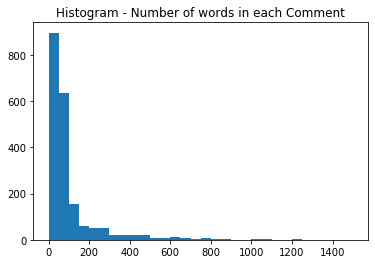

In [33]:
len_comment = [len(i) for i in (train['comment'])]
plt.hist(len_comment, bins=30, range=(0,1500))
plt.title('Histogram - Number of words in each Comment');

In [34]:
train['category'].value_counts(normalize=True)

1    0.500501
0    0.499499
Name: category, dtype: float64

Train / Test Split

In [77]:
# Create train_test_split.
X_train, X_test, y_train, y_test = train_test_split(train[['comment']],
                                                    train['category'],
                                                    test_size = 0.25,
                                                    stratify = train['category'],
                                                    random_state = 42)

# Data-Pre-Processing

In [78]:
import string
exclude_punct = list(string.punctuation)
positive_words = ['best','new','happy','love', 'great', 'tasty', 'delicious', 'amazing', 'great', 'exciting', 'flavorful', 'satisfying', 'friendly', 'good', 'nice', 'sweet', 'fun', 'engaging']
negative_words = ['bad', 'poor', 'gross', 'crappy', 'ew', 'slow', 'disgusting', 'rude', 'hate', 'sad', 'not', 'disgrace', 'disappointing', 'uncomfortable', 'unfriendly']
country = ['chinese','china','japanese','italian','japan','year','day','time','would','want','get','restaurant','found','taste','help','thank','homemade','com','share','master','https','http','know','food','like','make','cook','recipe']      
# Import stopwords.
nltk.download('stopwords')
from nltk.corpus import stopwords # Import the stopword list

def comment_to_words(raw_comment):
    # FROM : lecture 5.03
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    
    # 1. Remove HTML.
    comment_text = BeautifulSoup(raw_comment).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", comment_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    #all_stop=stopwords.words('english').union(positive_words, negative_words)
    stops = set(stopwords.words('english')).union(country, positive_words, negative_words)
    #stops = set(all_stop)
    
    # 5. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    # Instantiate lemmatizer. 
    lemmatizer = WordNetLemmatizer()
    # Lemmatize tokens.
    tokens_lem = [lemmatizer.lemmatize(i) for i in meaningful_words]
    # Instantiate object of class PorterStemmer.
    p_stemmer = PorterStemmer()
    # Stem tokens.
    tokens_stem = [p_stemmer.stem(i)  for i in tokens_lem]

    # 6. Join the words back into one string separated by space, 
    # and return the result.
    
    return(" ".join(tokens_stem))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yingr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [79]:
# Get the number of reviews based on the dataframe size.
total_comment = train.shape[0]
print(f'There are {total_comment} comments.')

There are 1998 comments.


In [9]:
#X_train['comment']

In [80]:
# Initialize an empty list to hold the clean reviews.
clean_train_comments = []
clean_test_comments = []
clean_pred_comments = []

print("Cleaning and parsing the training set comments...")
# For every comment in our training set...
for train_comment in X_train['comment']  :
    # Convert review to words, then append to clean_train_reviews.
    clean_train_comments.append(comment_to_words(train_comment))

# Let's do the same for our testing set.
print("Cleaning and parsing the testing set comments...")
for test_comment in X_test['comment']:
    clean_test_comments.append(comment_to_words(test_comment))
    
print("Cleaning and parsing the pred (cooking post) set comments...")
for pred_comment in data_pred['comment']:
    clean_pred_comments.append(comment_to_words(pred_comment))

Cleaning and parsing the training set comments...
Cleaning and parsing the testing set comments...
Cleaning and parsing the pred (cooking post) set comments...


In [40]:
#clean_pred_comments[:5]

In [81]:
len(clean_train_comments)

1498

# Modeling

In [82]:
X_train = clean_train_comments
X_test = clean_test_comments
X_pred = clean_pred_comments

In [83]:
y_train.shape

(1498,)

In [84]:
# Instantiate the "CountVectorizer" object, which is sklearn's
# bag of words tool.
cv = CountVectorizer( max_features = 5000) 

In [105]:
# fit_transform() does two things: First, it fits the model and 
# learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a 
# list of strings.
train_data_features_cv =cv.fit_transform(clean_train_comments)
test_data_features_cv =cv.transform(clean_test_comments)

In [106]:
print(train_data_features_cv.shape)

(1498, 3754)


In [107]:
vocab = cv.get_feature_names()
len(vocab)

3754

In [108]:
train_words = pd.DataFrame(train_data_features_cv.todense(), columns=vocab)

In [109]:
#train_words
train_words.sum().sort_values(ascending=False)

tri              114
burger           113
ramen            111
sauc             110
made             108
                ... 
melonpan           1
meh                1
mee                1
mediterranean      1
leek               1
Length: 3754, dtype: int64

(array([3.486e+03, 1.600e+02, 6.200e+01, 1.700e+01, 8.000e+00, 4.000e+00,
        8.000e+00, 1.000e+00, 3.000e+00, 5.000e+00]),
 array([  1. ,  12.3,  23.6,  34.9,  46.2,  57.5,  68.8,  80.1,  91.4,
        102.7, 114. ]),
 <a list of 10 Patch objects>)

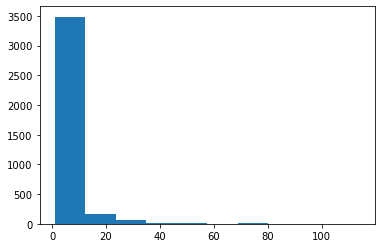

In [110]:
plt.hist(train_words.sum())


In [111]:
logreg = LogisticRegression(random_state = 42)
logreg.fit(train_data_features_cv, y_train)
print(f'Train score: {logreg.score(train_data_features_cv, y_train)}')
print(f'Cross val score: {cross_val_score(logreg, train_data_features_cv, y_train, cv=5)}')
print(f'Test score: {logreg.score(test_data_features_cv, y_test)}')
logreg.coef_

Train score: 0.9833110814419226
Cross val score: [0.84       0.82666667 0.79333333 0.83946488 0.84280936]
Test score: 0.866


array([[ 0.01138306,  0.03451968,  0.00144204, ..., -0.26920829,
        -0.11162136, -0.04971098]])

In [112]:
len(cv.get_feature_names())

3754

In [113]:
features_df_cv = pd.DataFrame(data = logreg.coef_[0], 
                           index = cv.get_feature_names(),
                           columns = ['logreg_coef'])
features_df_cv['abs_coef'] = features_df_cv['logreg_coef'].abs()
features_df_cv[features_df_cv['abs_coef']>1.4]['logreg_coef'].sort_values(ascending=False)

ramen          2.458660
sushi          2.171620
curri          1.947884
soba           1.797965
osaka          1.485584
okonomiyaki    1.475295
tokyo          1.423257
sear          -1.401627
ribey         -1.978237
burger        -2.286624
Name: logreg_coef, dtype: float64

In [124]:
custom_stop_cv = features_df_cv[features_df_cv['abs_coef']<0.5].index
custom_stop_list_cv = list(custom_stop_cv)
len(custom_stop_list_cv)

3520

In [125]:
tf = TfidfVectorizer()
train_data_features_tf =tf.fit_transform(clean_train_comments)
test_data_features_tf =tf.transform(clean_test_comments)
vocab = tf.get_feature_names()
print('len(vocab) : {len(vocab)}')
logreg = LogisticRegression(random_state = 42)
logreg.fit(train_data_features_tf, y_train)
print(f'Train score: {logreg.score(train_data_features_tf, y_train)}')
print(f'Cross val score: {cross_val_score(logreg, train_data_features_tf, y_train, cv=5)}')
print(f'Test score: {logreg.score(test_data_features_tf, y_test)}')
print(f'logreg tf : {logreg.coef_}')
features_df_tf = pd.DataFrame(data = logreg.coef_[0], 
                           index = tf.get_feature_names(),
                           columns = ['logreg_coef'])
features_df_tf['abs_coef'] = features_df_tf['logreg_coef'].abs()
features_df_tf[features_df_tf['abs_coef']>1.4]['logreg_coef'].sort_values(ascending=False)

len(vocab) : {len(vocab)}
Train score: 0.965287049399199
Cross val score: [0.81333333 0.84666667 0.79666667 0.83946488 0.8361204 ]
Test score: 0.88
logreg tf : [[ 0.05579624  0.03732709  0.03758717 ... -0.20279437 -0.11009249
  -0.09087619]]


ramen          3.578363
sushi          2.655053
curri          2.605436
soba           2.106418
tokyo          1.883549
osaka          1.827513
miso           1.681605
tonkatsu       1.571478
udon           1.564670
okonomiyaki    1.549471
takoyaki       1.434477
dumpl         -1.401908
dri           -1.406432
pizza         -1.426020
bacon         -1.462835
cheeseburg    -1.531074
fri           -1.687857
pasta         -1.705473
sear          -1.833276
steak         -1.909649
ribey         -2.435731
burger        -3.490065
Name: logreg_coef, dtype: float64

In [126]:
custom_stop_tf = features_df_tf[features_df_tf['abs_coef']<0.5].index
custom_stop_list_tf = list(custom_stop_tf)
len(custom_stop_list_tf)

3547

Running Models

In [128]:
pipe_cv = Pipeline([('cv', CountVectorizer()),
                    ('logreg', LogisticRegression())])
cv_params = {'cv__ngram_range': [(1, 1), (1,2)],
             'cv__max_df': [ .9, .95],
             'cv__min_df': [1, 2],
             'cv__stop_words': [None,custom_stop_list_tf],
             'cv__max_features': [2000, 3000, 4000],
            # 'logreg__solver' : ['liblinear', 'lbfgs'], #default=lbfgs
             'logreg__penalty': ['l1', 'l2'],           #default =l2, L1=Lasso
             'logreg__C': [0.01, 0.1, 1, 10]           #default=10
             }

cv_grid = GridSearchCV(pipe_cv, cv_params ) 
cv_grid.fit(X_train, y_train)
print('Using CountVectorizer')
print(f'training Score: {cv_grid.score(X_train, y_train)}')
print(f'Testing Score: {cv_grid.score(X_test, y_test)}')

C:\Users\yingr\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\yingr\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Using CountVectorizer
training Score: 0.8778371161548731
Testing Score: 0.828


In [129]:
cv_grid.best_params_

{'cv__max_df': 0.9,
 'cv__max_features': 2000,
 'cv__min_df': 1,
 'cv__ngram_range': (1, 1),
 'cv__stop_words': ['aa',
  'aasian',
  'ab',
  'abalon',
  'abdeb',
  'abl',
  'abroad',
  'abruzzes',
  'absolut',
  'absorb',
  'aburaag',
  'abz',
  'ac',
  'academia',
  'accept',
  'accompani',
  'accordingli',
  'account',
  'accur',
  'achiev',
  'acid',
  'acorn',
  'acquir',
  'across',
  'act',
  'activ',
  'actual',
  'acvofn',
  'ad',
  'adam',
  'adapt',
  'add',
  'addit',
  'adjust',
  'adobo',
  'adopt',
  'adriat',
  'advanc',
  'advantag',
  'adventur',
  'advertis',
  'advic',
  'advis',
  'adzuki',
  'ae',
  'aefda',
  'aesthet',
  'af',
  'affili',
  'afor',
  'afraid',
  'aftermath',
  'afternoon',
  'afuri',
  'age',
  'ago',
  'agre',
  'agriturismi',
  'ah',
  'ahaha',
  'ahead',
  'ahi',
  'aichi',
  'aim',
  'aioli',
  'air',
  'airflow',
  'airfryer',
  'akasaka',
  'akedo',
  'akihabara',
  'albertan',
  'album',
  'alcohol',
  'alfredo',
  'alioli',
  'alkalin',
 

In [130]:
cv_best_param = cv_grid.best_params_

In [131]:
cv_grid.best_estimator_

Pipeline(memory=None,
         steps=[('cv',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.9,
                                 max_features=2000, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=['aa', 'aasian', 'ab', 'abalon',
                                             'abdeb', 'abl', 'abroad',
                                             'abruzzes', 'absolut', 'absorb',
                                             'aburaa...
                                             'actual', 'acvofn', 'ad', 'adam', ...],
                                 strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabu

In [133]:
pipe_tf = Pipeline([('tf', TfidfVectorizer()),
                    ('logreg', LogisticRegression())])
tf_params = {'tf__ngram_range': [(1, 1), (1,2)],
             'tf__max_df': [ 0.9, .95],
             'tf__min_df': [1, 2],
             'tf__max_features': [1000,2000, 3000],
             'tf__stop_words': [None,custom_stop_list_tf],
             #'logreg__solver' : ['liblinear', 'lbfgs'], #default=lbfgs
             'logreg__penalty': ['l1', 'l2'],           #default =l2, L1=Lasso
             'logreg__C': [0.01, 0.1, 1, 10]           #default=10
             }
tf_grid = GridSearchCV(pipe_tf, tf_params)
tf_grid.fit(X_train, y_train)
print('Using TfidfVectorizer')
print(f'training Score: {tf_grid.score(X_train, y_train)}')
print(f'Testing Score: {tf_grid.score(X_test, y_test)}')

C:\Users\yingr\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\yingr\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\yingr\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\yingr\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\yingr\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

Using TfidfVectorizer
training Score: 0.863150867823765
Testing Score: 0.816


In [134]:
tf_grid.best_params_

{'logreg__C': 1,
 'logreg__penalty': 'l2',
 'tf__max_df': 0.9,
 'tf__max_features': 1000,
 'tf__min_df': 1,
 'tf__ngram_range': (1, 1),
 'tf__stop_words': ['aa',
  'aasian',
  'ab',
  'abalon',
  'abdeb',
  'abl',
  'abroad',
  'abruzzes',
  'absolut',
  'absorb',
  'aburaag',
  'abz',
  'ac',
  'academia',
  'accept',
  'accompani',
  'accordingli',
  'account',
  'accur',
  'achiev',
  'acid',
  'acorn',
  'acquir',
  'across',
  'act',
  'activ',
  'actual',
  'acvofn',
  'ad',
  'adam',
  'adapt',
  'add',
  'addit',
  'adjust',
  'adobo',
  'adopt',
  'adriat',
  'advanc',
  'advantag',
  'adventur',
  'advertis',
  'advic',
  'advis',
  'adzuki',
  'ae',
  'aefda',
  'aesthet',
  'af',
  'affili',
  'afor',
  'afraid',
  'aftermath',
  'afternoon',
  'afuri',
  'age',
  'ago',
  'agre',
  'agriturismi',
  'ah',
  'ahaha',
  'ahead',
  'ahi',
  'aichi',
  'aim',
  'aioli',
  'air',
  'airflow',
  'airfryer',
  'akasaka',
  'akedo',
  'akihabara',
  'albertan',
  'album',
  'alcoho

In [135]:
tf_best_param = tf_grid.best_params_

 Bayes classifier

In [137]:
cv = CountVectorizer(cv_best_param)
X_train_cv = cv.fit_transform(X_train)
X_test_cv  = cv.transform(X_test)
mulnb = MultinomialNB()
mulnb.fit(X_train_cv, y_train)
print('Using MultinomialNB')
print(f'Training Score: {mulnb.score(X_train_cv, y_train)}')
print(f'Testing Score: {mulnb.score(X_test_cv, y_test)}')

Using MultinomialNB
Training Score: 0.9459279038718291
Testing Score: 0.872


In [143]:
tf = TfidfVectorizer(tf_best_param)
X_train_tf = tf.fit_transform(X_train).toarray()
X_test_tf = tf.transform(X_test).toarray()
gaunb = GaussianNB()
gaunb.fit(X_train_tf, y_train)
print('Using GaussianNB')
print(f'Training Score: {gaunb.score(X_train_tf, y_train)}')
print(f'Testing Score: {gaunb.score(X_test_tf, y_test)}')

Using GaussianNB
Training Score: 0.9472630173564753
Testing Score: 0.77


In [146]:
rf=RandomForestClassifier(random_state = 42,
                         n_estimators=50)
extra = ExtraTreesClassifier(random_state=42,
                            n_estimators=50)
rfcv = cross_val_score(rf,X_train_cv, y_train, cv=5)
print(rfcv)
print(rfcv.mean())
rf_params={
    'max_features' : ['auto', 2, 1000],
    'n_estimators': [1000,2000],
    'max_depth' : [6, 8, 20] 
}
grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=5)
grid.fit(X_train_cv, y_train)
print(grid.best_score_) # cross val score
grid.best_params_

[0.80666667 0.78333333 0.76       0.82274247 0.79264214]
0.793076923076923
0.8064085447263017


{'max_depth': 20, 'max_features': 2, 'n_estimators': 1000}

Model Metrics

In [138]:
train_preds = mulnb.predict(X_train_cv)
test_preds = mulnb.predict(X_test_cv)
pred_proba = mulnb.predict_proba(X_test_cv)
pred_proba
pred_proba = [i[1] for i in mulnb.predict_proba(X_test_cv)]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba,
                        'X_test': X_test})
pred_df

,true_values,pred_probs,X_test
370,1,0.759611,cheap appet
1654,0,0.065326,underag burger joint san antonio
778,1,0.729044,hot deep fri mackerel
1646,0,0.000473,made hungri jack burger king angriest whopper ...
171,1,0.986132,variat tamago kake gohan
...,...,...,...
320,1,0.998501,crave gyudon learn onsen tamago
636,1,0.994148,match sushi sagami nj
1232,0,0.781319,l gn l f rn wh th r f r th one
296,1,0.936553,unbox lucki bag fukubukuro


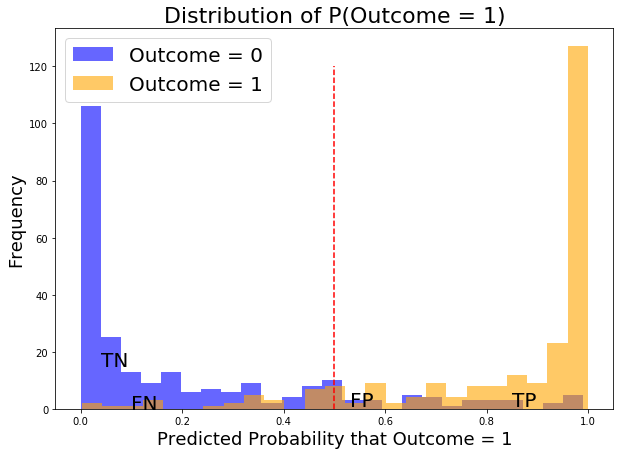

In [139]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 120,
           color = 'r',
           linestyle = '--')

# Add annotations for TN, FN, TP, FP.
plt.annotate(xy = (0.04, 15),
             s = 'TN',
             size = 20)

plt.annotate(xy = (0.1, 0),
             s = 'FN',
             size = 20)

plt.annotate(xy = (0.85, 1),
             s = 'TP',
             size = 20)

plt.annotate(xy = (0.53, 1),
             s = 'FP',
             size = 20)

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20);

In [140]:
precision_train=precision_score(y_train, train_preds, average='weighted')
precision_test=precision_score(y_test,test_preds,average='weighted')
recall_train=recall_score(y_train,train_preds,average='weighted')
recall_test=recall_score(y_test,test_preds,average='weighted')

In [141]:
print(f'train accuracy score : {accuracy_score(y_train,train_preds)}')
print(f'test accuracy score : {accuracy_score(y_test,test_preds)}')
print(f'train precision score : {precision_train }')  #tp / (tp + fp)
print(f'test precision score : {precision_test}')
print(f'train recall score : {recall_train}') #  tp / (tp + fn)
print(f'test recall score : {recall_test}')
tn,fp,fn,tp  = confusion_matrix(y_train,train_preds).ravel()
print(f'train specificity score : {tn/(tn+fp)}') # tn/(tn+fp)
tn,fp,fn,tp  = confusion_matrix(y_test,test_preds).ravel()  
print(f'test specificity score : {tn/(tn+fp)}') # tn/(tn+fp)
               

train accuracy score : 0.9459279038718291
test accuracy score : 0.872
train precision score : 0.9464228900629087
test precision score : 0.8731702619414484
train recall score : 0.9459279038718291
test recall score : 0.872
train specificity score : 0.929144385026738
test specificity score : 0.844


# Making-Prediction

Making Prediction on New Data

In [152]:
X_pred_cv  = cv.transform(clean_pred_comments)
data_pred['category'] = mulnb.predict(X_pred_cv)

In [153]:
data_pred['category'].value_counts()

0    615
1    383
Name: category, dtype: int64

In [154]:
data_pred.to_csv('./cooking_pred.csv',index=None)